In [23]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

### Import necessary components: pre-trained BiT-M model & CIFAR-10 dataset

In [24]:
# Import ResNet-50x3 pre-trained on ILSVRC-2012
model_url = "https://tfhub.dev/google/bit/m-r50x3/ilsvrc2012_classification/1"
module = hub.KerasLayer(model_url)

In [25]:
# Import CIFAR-10 dataset for downstream task
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Set number of classes
NUM_CLASSES = 10

# Set number of examples per class for fine-tuning
num_examples_per_class = 5

In [26]:
# Check training set feautre & label shapes
print("Training set shape:")
print("Features: {}".format(X_train.shape))
print("Labels: {}".format(y_train.shape))

# Check test set feature & label shapes
print("\nTest set shape:")
print("Features: {}".format(X_test.shape))
print("Labels: {}".format(y_test.shape))

Training set shape:
Features: (50000, 32, 32, 3)
Labels: (50000, 1)

Test set shape:
Features: (10000, 32, 32, 3)
Labels: (10000, 1)


In [27]:
# If necessary, add new head to BiT model for fine-tuning
class MyBiTModel(tf.keras.Model):

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off here since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Construct few-shot training set & 1k-sample test set

In [28]:
def create_train_set(X_train, y_train, num_examples_per_class=5):
  """Given training features & labels, create random few-shot subset to use in model fine-tuning"""
  
  # Get indices for training set examples
  train_indices = {}
  for i in range(NUM_CLASSES):
    train_indices[i] = np.random.choice(np.where(y_train == i)[0], num_examples_per_class, replace=False)

  # Create arrays using indices
  X_train_fewshot = np.take(X_train, indices=[ind for cls in train_indices for ind in train_indices[cls]], axis=0)
  y_train_fewshot = np.take(y_train, indices=[ind for cls in train_indices for ind in train_indices[cls]], axis=0)

  return train_indices, X_train_fewshot, y_train_fewshot

In [29]:
# Create training set
train_indices, X_train_fewshot, y_train_fewshot = create_train_set(X_train, y_train, num_examples_per_class=num_examples_per_class)

# Check training set shapes
print("{}-shot training set shape:".format(num_examples_per_class))
print("Features: {}".format(X_train_fewshot.shape))
print("Labels: {}".format(y_train_fewshot.shape))

5-shot training set shape:
Features: (50, 32, 32, 3)
Labels: (50, 1)


In [30]:
def print_trainingset(X_train, train_indices):
  """Plot images in fewshot training set given full training set & dictionary of fewshot indices"""

  # Create image grid
  fig = plt.figure(figsize=(12, 5))
  ig = ImageGrid(fig, 111, (num_examples_per_class, 10))
  fig.suptitle('{}-shot CIFAR-10 training dataset'.format(num_examples_per_class));

  # Display images
  for col, cls in enumerate(train_indices):
    for row, i in enumerate(train_indices[cls]):
      img = X_train[i]
      ax = ig.axes_column[col][row]
      ax.imshow(img)
      ax.set_axis_off()

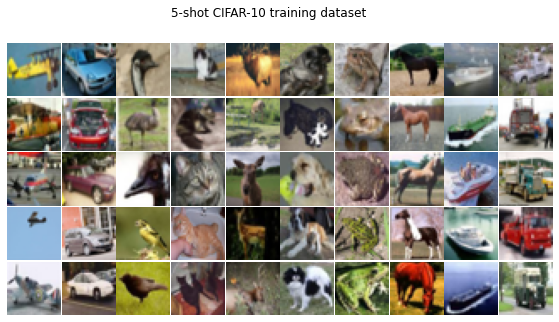

In [31]:
# Display training set images
print_trainingset(X_train, train_indices)

In [32]:
def create_test_set(X_test, y_test, num_samples=1000):
  """Given test features & labels, create random sample to use for testing"""

  # Get indices for test set examples
  test_indices = np.random.choice(np.where(y_test)[0], num_samples, replace=False)

  # Create arrays using indices
  X_test_new = np.take(X_test, indices=test_indices, axis=0)
  y_test_new = np.take(y_test, indices=test_indices, axis=0)

  return X_test_new, y_test_new

In [33]:
# Create test set
X_test_new, y_test_new = create_test_set(X_test, y_test)

# Check test set shapes
print("1000-sample test set shape:")
print("Features: {}".format(X_test_new.shape))
print("Labels: {}".format(y_test_new.shape))

1000-sample test set shape:
Features: (1000, 32, 32, 3)
Labels: (1000, 1)


In [34]:
def create_tf_dataset(X, y):
  """Re-combine features and labels into tf dataset for pipeline processing"""

  ds = tf.data.Dataset.from_tensor_slices({'image': X, 'label': y})

  return ds

In [35]:
# Create train & test datasets from feature & labels arrays
ds_train = create_tf_dataset(X_train_fewshot, y_train_fewshot)
ds_test = create_tf_dataset(X_test_new, y_test_new)

In [36]:
# Check shapes:
print("Training TensorFlow dataset:")
print("Dataset description: {}".format(ds_train))
print("Dataset length: {}".format(tf.data.experimental.cardinality(ds_train)))

print("\nTest TesorFlow dataset:")
print("Dataset description: {}".format(ds_test))
print("Dataset length: {}".format(tf.data.experimental.cardinality(ds_test)))

Training TensorFlow dataset:
Dataset description: <TensorSliceDataset shapes: {image: (32, 32, 3), label: (1,)}, types: {image: tf.uint8, label: tf.uint8}>
Dataset length: 50

Test TesorFlow dataset:
Dataset description: <TensorSliceDataset shapes: {image: (32, 32, 3), label: (1,)}, types: {image: tf.uint8, label: tf.uint8}>
Dataset length: 1000


### Pre-processing & hyperparameter setting

In [37]:
#@title Set dataset-dependent hyperparameters

image_size = "<= 96x96 px" #@param ["<= 96x96 px","> 96x96 px"]
dataset_size = "< 20k examples" #@param ["< 20k examples", "20k-500k examples", "> 500k examples"]

# If images <= 96x96 px, crop to 128x128
if image_size == "<= 96x96 px":
  resize_to = 160
  crop_to = 128
# If images > 96x96 px, crop to 480x480
else:
  resize_to = 512
  crop_to = 480

# Set schedule length & learning rate decay based on dataset size
if dataset_size == "< 20k examples":
  schedule_length = 500
  schedule_boundaries = [200, 300, 400]
elif dataset_size == "20k-500k examples":
  schedule_length = 10000
  schedule_boundaries = [3000, 6000, 9000]
else:
  schedule_length = 20000
  schedule_boundaries = [6000, 12000, 18000]

In [38]:
# Define preprocessing steps

def cast_to_tuple(features):
  return (features['image'], features['label'])

# Augment & pre-process data for task training
def preprocess_train(features):
  # Apply random horizontal flip
  features['image'] = tf.image.random_flip_left_right(features['image'])
  # Resize image
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  # Crop image
  features['image'] = tf.image.random_crop(features['image'], [crop_to, crop_to, 3])
  # Record feature values as floats <= 1
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0

  return features

# Pre-process data for testing
def preprocess_test(features):
  # Resize image
  features['image'] = tf.image.resize(features['image'], [resize_to, resize_to])
  # Record feature values as floats <= 1
  features['image'] = tf.cast(features['image'], tf.float32) / 255.0

  return features

In [39]:
# Set model training parameters
dataset_num_train_examples = NUM_CLASSES * num_examples_per_class
batch_size = 50
steps_per_epoch = 10
lr = 0.003 

# Decay learning rate by factor of 10 at schedule_boundaries
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=schedule_boundaries, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])

# Define optimizer and loss function
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Fine-tune model

In [40]:
# Create train pipeline
def create_train_pipeline(ds_train):
  pipeline_train = (ds_train
                    .shuffle(10000)
                    .repeat(int(schedule_length * batch_size / dataset_num_train_examples * steps_per_epoch) + 1 + 50)  # repeat dataset_size / num_steps
                    .map(preprocess_train, num_parallel_calls=8)
                    .batch(batch_size)
                    .map(cast_to_tuple)   # for keras model.fit
                    .prefetch(2))
  return pipeline_train

# Create test pipeline
def create_test_pipeline(ds_test):
  pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=1)
                   .map(cast_to_tuple)  # for keras model.fit
                   .batch(batch_size)
                   .prefetch(2))
  return pipeline_test

In [41]:
# Compile model
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [42]:
# Fine-tune model
history = model.fit(
    create_train_pipeline(ds_train),
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=create_test_pipeline(ds_test)
)

Epoch 1/5
10/10 [==============================] - 841s 89s/step - loss: 1.4544 - accuracy: 0.7069 - val_loss: 0.6014 - val_accuracy: 0.8210
Epoch 2/5
10/10 [==============================] - 822s 89s/step - loss: 0.0706 - accuracy: 0.9954 - val_loss: 0.6310 - val_accuracy: 0.8020
Epoch 3/5
10/10 [==============================] - 827s 90s/step - loss: 0.0206 - accuracy: 0.9992 - val_loss: 0.6135 - val_accuracy: 0.8220
Epoch 4/5
10/10 [==============================] - 825s 89s/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.6420 - val_accuracy: 0.8160
Epoch 5/5
10/10 [==============================] - 817s 88s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.6620 - val_accuracy: 0.8110


In [43]:
# Save validation accuracy
val_accuracies = []
val_accuracies.append(history.history['val_accuracy'][-1])

### Model iterations

In [44]:
# Run 4 additional iterations, for 5 total runs
for i in range(4):
  # Create train and test sets
  train_indices, X_train_fewshot, y_train_fewshot = create_train_set(X_train, y_train, num_examples_per_class=num_examples_per_class)
  X_test_new, y_test_new = create_test_set(X_test, y_test)

  # Create train & test datasets from feature & label arrays
  ds_train = create_tf_dataset(X_train_fewshot, y_train_fewshot)
  ds_test = create_tf_dataset(X_test_new, y_test_new)

  # Create model
  model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

  # Run model
  history = model.fit(
    create_train_pipeline(ds_train),
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=create_test_pipeline(ds_test)
  )

  # Save accuracy
  val_accuracies.append(history.history['val_accuracy'][-1])

Epoch 1/5
10/10 [==============================] - 823s 89s/step - loss: 0.7173 - accuracy: 0.7771 - val_loss: 0.5342 - val_accuracy: 0.8580
Epoch 2/5
10/10 [==============================] - 807s 87s/step - loss: 0.0717 - accuracy: 0.9856 - val_loss: 0.4529 - val_accuracy: 0.8590
Epoch 3/5
10/10 [==============================] - 814s 88s/step - loss: 0.0252 - accuracy: 0.9994 - val_loss: 0.4538 - val_accuracy: 0.8740
Epoch 4/5
10/10 [==============================] - 806s 87s/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.5018 - val_accuracy: 0.8600
Epoch 5/5
10/10 [==============================] - 808s 88s/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.4805 - val_accuracy: 0.8670
Epoch 1/5
10/10 [==============================] - 819s 88s/step - loss: 0.6882 - accuracy: 0.8343 - val_loss: 0.6543 - val_accuracy: 0.8310
Epoch 2/5
10/10 [==============================] - 816s 88s/step - loss: 0.1893 - accuracy: 0.9303 - val_loss: 0.4968 - val_accuracy: 0.8740
Epoch 3/5
10/

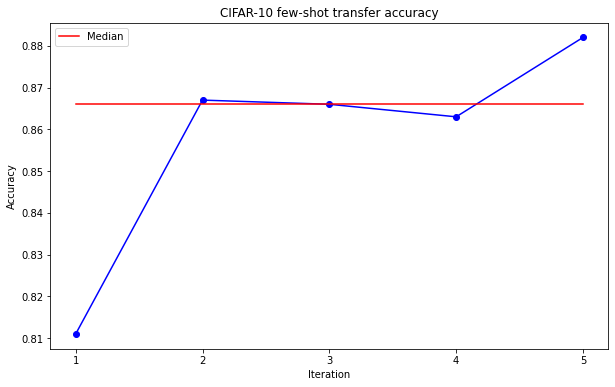

In [52]:
# Plot final accuracies
plt.figure(figsize=(10, 6))

iter = np.arange(1,6)
median = [np.median(val_accuracies) for i in iter]

plt.plot(iter, val_accuracies, '-bo')
plt.plot(iter, median, '-r', label='Median')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks([1,2,3,4,5])
plt.legend()
plt.title('CIFAR-10 few-shot transfer accuracy')
plt.show()